In [1]:
import pandas as pd
import numpy as np
import json
import os
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# Load the JSON file
with open("../data/raw_credit_applications.json", "r") as f:
    raw_data = json.load(f)

# Flatten nested JSON structure
df_original = pd.json_normalize(raw_data)

# Create working copy for analysis
df = df_original.copy()

print("Dataset loaded successfully")
print(f"Original shape: {df.shape[0]} records, {df.shape[1]} columns")
df.head()

Dataset loaded successfully
Original shape: 502 records, 21 columns


,_id,spending_behavior,processing_timestamp,applicant_info.full_name,applicant_info.email,applicant_info.ssn,applicant_info.ip_address,applicant_info.gender,applicant_info.date_of_birth,applicant_info.zip_code,...,financials.credit_history_months,financials.debt_to_income,financials.savings_balance,decision.loan_approved,decision.rejection_reason,loan_purpose,decision.interest_rate,decision.approved_amount,financials.annual_salary,notes
0,app_200,"[{'category': 'Shopping', 'amount': 480}, {'ca...",2024-01-15T00:00:00Z,Jerry Smith,jerry.smith17@hotmail.com,596-64-4340,192.168.48.155,Male,2001-03-09,10036,...,23,0.20,31212,False,algorithm_risk_score,NaN,NaN,NaN,NaN,NaN
1,app_037,"[{'category': 'Rent', 'amount': 608}, {'catego...",NaN,Brandon Walker,brandon.walker2@yahoo.com,425-69-4784,10.1.102.112,M,1992-03-31,10032,...,51,0.18,17915,False,algorithm_risk_score,NaN,NaN,NaN,NaN,NaN
2,app_215,"[{'category': 'Rent', 'amount': 109}]",NaN,Scott Moore,scott.moore94@mail.com,370-78-5178,10.240.193.250,Male,1989-10-24,10075,...,41,0.21,37909,True,NaN,vacation,3.7,59000.0,NaN,NaN
3,app_024,"[{'category': 'Fitness', 'amount': 575}]",NaN,Thomas Lee,thomas.lee6@protonmail.com,194-35-1833,192.168.175.67,Male,1983-04-25,10077,...,70,0.35,0,True,NaN,NaN,4.3,34000.0,NaN,NaN
4,app_184,"[{'category': 'Entertainment', 'amount': 463}]",2024-01-15T00:00:00Z,Brian Rodriguez,brian.rodriguez86@aol.com,480-41-2475,172.29.125.105,M,1999-05-21,10080,...,14,0.23,31763,False,algorithm_risk_score,NaN,NaN,NaN,NaN,NaN


In [2]:
os.getcwd()

'C:\\Users\\92314\\OneDrive - Nova SBE\\DataG\\dego-project-team14\\notebooks'

# Gender Analysis

In [3]:
gender_col = 'applicant_info.gender'
decision_col = 'decision.loan_approved'

# 1) Normalize gender values
df['gender_clean'] = df[gender_col].replace({
    'M': 'Male',
    'F': 'Female'
})
# 2) Keep only Male/Female for fairness metrics and plots
mask = df['gender_clean'].isin(['Male', 'Female'])

approval_by_gender = (
    df[mask]
      .groupby('gender_clean')[decision_col]
      .mean()
      .rename('approval_rate')
)

approval_by_gender

gender_clean
Female    0.505976
Male      0.657258
Name: approval_rate, dtype: float64

In [4]:
# 3) Disparate impact + demographic parity difference
rate_priv = approval_by_gender['Male']
rate_unpriv = approval_by_gender['Female']

di_ratio = rate_unpriv / rate_priv
demographic_parity_diff = rate_unpriv - rate_priv

print(f"Male approval rate:   {rate_priv:.3f}")
print(f"Female approval rate: {rate_unpriv:.3f}")
print(f"Disparate Impact ratio: {di_ratio:.3f}")
print(f"Demographic Parity diff: {demographic_parity_diff:.3f}")

Male approval rate:   0.657
Female approval rate: 0.506
Disparate Impact ratio: 0.770
Demographic Parity diff: -0.151


In [5]:
# Chi-square test of independence: gender vs loan approval
cont_gender = pd.crosstab(df[mask]['gender_clean'], df[mask][decision_col])
chi2_g, p_g, dof_g, _ = chi2_contingency(cont_gender)

print("Chi-square test: Gender vs Loan Approval")
print(f"  Chi2 = {chi2_g:.4f}, p-value = {p_g:.4f}, dof = {dof_g}")
if p_g < 0.05:
    print("  Result: Statistically significant difference in approval rates by gender.")
else:
    print("  Result: No statistically significant difference detected.")


Chi-square test: Gender vs Loan Approval
  Chi2 = 11.1156, p-value = 0.0009, dof = 1
  Result: Statistically significant difference in approval rates by gender.


In [6]:
# Outcome metrics by gender: interest rate and approved amount (approved loans only)
interest_col = 'decision.interest_rate'
amount_col = 'decision.approved_amount'

approved_mask = mask & (df[decision_col] == True)

outcomes_by_gender = (
    df[approved_mask]
      .groupby('gender_clean')[[interest_col, amount_col]]
      .mean()
      .rename(columns={
          interest_col: 'avg_interest_rate',
          amount_col: 'avg_approved_amount'
      })
)

outcomes_by_gender

,avg_interest_rate,avg_approved_amount
gender_clean,,
Female,4.488189,46669.291339
Male,4.628221,48963.190184


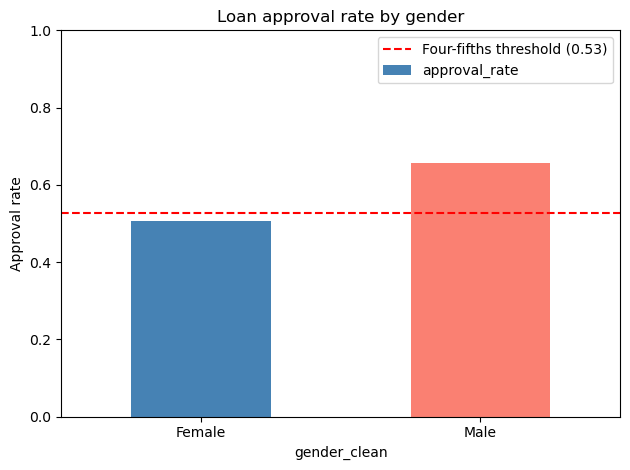

In [7]:
fig, ax = plt.subplots()
approval_by_gender.plot(kind='bar', ax=ax, rot=0, color=['steelblue', 'salmon'])
ax.set_ylabel('Approval rate')
ax.set_title('Loan approval rate by gender')
ax.set_ylim(0, 1)
ax.axhline(y=rate_priv * 0.8, color='red', linestyle='--', linewidth=1.5,
           label=f'Four-fifths threshold ({rate_priv * 0.8:.2f})')
ax.legend()
plt.tight_layout()
plt.show()


### Gender Bias – Disparate Impact and Outcomes

#### Gender Data Cleaning
The raw `applicant_info.gender` field contained multiple encodings: `Male`, 
`Female`, `M`, and `F`. To ensure consistency, we mapped `M` → `Male` and 
`F` → `Female` into a new `gender_clean` variable. Records with missing or 
invalid gender values are retained in the dataset but excluded from binary 
fairness comparisons to avoid distorting the metrics.

#### Approval Rate Disparity
The loan approval rate is **65.7% for male applicants** and **50.6% for female 
applicants**, yielding a disparate impact (DI) ratio of **0.770** — below the 
0.80 four-fifths threshold. This indicates potential disparate impact against 
female applicants under standard fairness guidelines. The demographic parity 
difference is **−15.1 percentage points**, meaning female applicants are 
substantially less likely to be approved than male applicants.

A chi-square test of independence confirms this gap is statistically significant 
(χ² = 11.12, p = 0.0009), making it very unlikely to be due to random variation 
in the sample.

#### Outcome Metrics Among Approved Applicants
Among approved applicants, females receive a slightly lower average interest rate 
(4.49% vs 4.63%) but a notably lower average approved amount (€46,669 vs €48,963). 
This suggests that while approved women are not penalised on pricing, they 
systematically receive smaller loan amounts — meaning the disparity extends 
beyond the approval decision itself.

#### Possible Confounders
The observed gaps may be partly explained by financial variables that differ 
systematically by gender, such as income level, employment stability, 
debt-to-income ratio, and credit history length. These confounders do not 
eliminate the fairness concern but are important context — a model that 
conditions on these variables may show a reduced but not necessarily zero 
gender gap.

#### Suggested Mitigations
- **Reweighting**: Apply sample reweighting during model training to reduce 
  approval rate gaps across gender groups.
- **Threshold adjustment**: Use group-specific decision thresholds to equalise 
  approval rates or error rates across genders.
- **Regular monitoring**: Track the DI ratio on new data quarterly and trigger 
  a formal review if it falls below 0.80.


# Age Analysis

In [8]:
 dob_col = 'applicant_info.date_of_birth'

# Convert date_of_birth to datetime and compute age
df['dob'] = pd.to_datetime(df[dob_col], errors='coerce')
reference_year = 2024  # adjust if needed
df['age'] = reference_year - df['dob'].dt.year

# Create age buckets
age_bins = [0, 30, 50, 120]
age_labels = ['<30', '30-50', '50+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

df['age_group'].value_counts(dropna=False)


age_group
30-50    199
NaN      162
<30       78
50+       63
Name: count, dtype: int64

In [9]:
df['age'].isna().mean()

np.float64(0.32270916334661354)

In [10]:
decision_col = 'decision.loan_approved'

approval_by_age = (
    df.dropna(subset=['age_group'])
      .groupby('age_group', observed=False)[decision_col]
      .mean()
      .rename('approval_rate')
)

approval_by_age


age_group
<30      0.397436
30-50    0.623116
50+      0.619048
Name: approval_rate, dtype: float64

In [11]:
# Disparate impact for age: <30 (unprivileged) vs 30-50 (privileged)
rate_under30 = approval_by_age.loc['<30']
rate_30_50   = approval_by_age.loc['30-50']
rate_50_plus = approval_by_age.loc['50+']

di_under30_vs_3050   = rate_under30 / rate_30_50
di_3050_vs_50plus    = rate_30_50   / rate_50_plus
di_under30_vs_50plus = rate_under30 / rate_50_plus

print(f"DI  <30  vs 30-50: {di_under30_vs_3050:.3f}")
print(f"DI 30-50 vs  50+:  {di_3050_vs_50plus:.3f}")
print(f"DI  <30  vs  50+:  {di_under30_vs_50plus:.3f}")

DI  <30  vs 30-50: 0.638
DI 30-50 vs  50+:  1.007
DI  <30  vs  50+:  0.642


In [12]:
age_mask = df['age_group'].notna()
cont_age = pd.crosstab(df[age_mask]['age_group'], df[age_mask][decision_col])
chi2_a, p_a, dof_a, _ = chi2_contingency(cont_age)

print("Chi-square test: Age Group vs Loan Approval")
print(f"  Chi2 = {chi2_a:.4f}, p-value = {p_a:.4f}, dof = {dof_a}")
if p_a < 0.05:
    print("  Result: Statistically significant difference in approval rates by age group.")
else:
    print("  Result: No statistically significant difference detected.")


Chi-square test: Age Group vs Loan Approval
  Chi2 = 12.3893, p-value = 0.0020, dof = 2
  Result: Statistically significant difference in approval rates by age group.


In [13]:
# Disparate impact for age: additional pairwise comparisons
rate_50_plus = approval_by_age.loc['50+']

# 30-50 (unprivileged) vs 50+ (privileged)
di_age_30_50_vs_50_plus = rate_30_50 / rate_50_plus

# <30 (unprivileged) vs 50+ (privileged)
di_age_under30_vs_50_plus = rate_under30 / rate_50_plus

rate_50_plus, di_age_30_50_vs_50_plus, di_age_under30_vs_50_plus

(np.float64(0.6190476190476191),
 np.float64(1.0065713181291072),
 np.float64(0.6420118343195266))

In [14]:
# Outcome metrics by age group: interest rate and approved amount (approved loans only)
approved_by_age = df[~df['age_group'].isna() & (df[decision_col] == True)]

outcomes_by_age = (
    approved_by_age
      .groupby('age_group', observed=False)[[interest_col, amount_col]]
      .mean()
      .rename(columns={
          interest_col: 'avg_interest_rate',
          amount_col: 'avg_approved_amount'
      })
)

outcomes_by_age

,avg_interest_rate,avg_approved_amount
age_group,,
<30,4.564516,45064.516129
30-50,4.569355,48983.870968
50+,4.428205,50923.076923


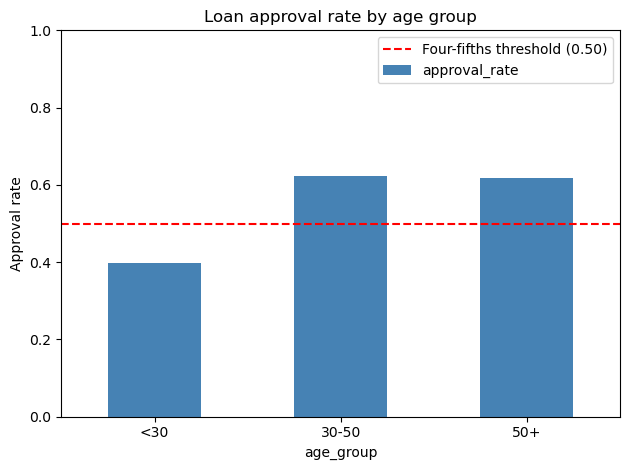

In [15]:
fig, ax = plt.subplots()
approval_by_age.plot(kind='bar', ax=ax, rot=0, color='steelblue')
ax.set_ylabel('Approval rate')
ax.set_title('Loan approval rate by age group')
ax.set_ylim(0, 1)
ax.axhline(y=rate_30_50 * 0.8, color='red', linestyle='--', linewidth=1.5,
           label=f'Four-fifths threshold ({rate_30_50 * 0.8:.2f})')
ax.legend()
plt.tight_layout()
plt.show()

### Age-Based Approval Patterns

#### Age Data Cleaning
The original `applicant_info.date_of_birth` field contained missing and 
inconsistently formatted values. We converted it to a proper datetime type 
and computed an approximate age using 2024 as the reference year. Invalid or 
missing dates were coerced to `NaT`, resulting in a `NaN` age for approximately 
**32.3% of records** (162 out of 502). These records are excluded from all 
age-group calculations and treated as a data-quality issue in their own right, 
since a high missingness rate can hide or distort age-related bias if not 
explicitly documented.

#### Age Group Distribution
After cleaning, the dataset contains **199 applicants aged 30–50**, **78 under 
30**, and **63 aged 50+**, with 162 records excluded due to missing date of birth.

#### Approval Rate Disparity
Approval rates differ substantially across age groups:
- **<30**: 39.7%
- **30–50**: 62.3%
- **50+**: 61.9%

Treating 30–50 as the privileged reference group, the disparate impact ratios are:

| Comparison | DI Ratio | Below 0.80 threshold? |
|---|---|---|
| <30 vs 30–50 | 0.638 | ✅ Yes |
| 30–50 vs 50+ | 1.007 | ❌ No |
| <30 vs 50+ | 0.642 | ✅ Yes |

The main disparity is between younger applicants (<30) and both older groups. 
The 30–50 and 50+ groups have near-identical approval rates (DI ≈ 1.0), 
confirming that age discrimination in this dataset is concentrated at the 
younger end.

A chi-square test of independence confirms this pattern is statistically 
significant (χ² = 12.39, p = 0.0020, dof = 2), making it very unlikely to 
be due to random variation in the sample.

#### Outcome Metrics Among Approved Applicants
Among approved applicants, average interest rates are very similar across 
age groups (4.43%–4.57%), and average approved amounts increase slightly 
with age:

| Age Group | Avg Interest Rate | Avg Approved Amount |
|---|---|---|
| <30 | 4.56% | €45,065 |
| 30–50 | 4.57% | €48,984 |
| 50+ | 4.43% | €50,923 |

Once approved, younger applicants receive broadly comparable interest rates 
but moderately lower loan amounts. The primary fairness concern therefore 
lies in **who gets approved**, not in the terms offered to those who are.

#### Possible Confounders
The approval gap for younger applicants is likely partly explained by 
financial variables that are correlated with age, such as shorter credit 
history, lower income, and higher debt-to-income ratios. These factors may 
drive model decisions independently of age itself. However, this does not 
eliminate the fairness concern — if these variables are themselves influenced 
by structural disadvantages faced by younger people, the model may still 
perpetuate indirect age discrimination.

#### Suggested Mitigations
- **Feature review**: Evaluate whether credit history length or income can 
  replace age-correlated features to reduce indirect discrimination.
- **Reweighting**: Apply sample reweighting to balance approval rates across 
  age groups during model training.
- **Threshold adjustment**: Consider group-specific decision thresholds for 
  younger applicants where disparities cannot be justified by risk alone.
- **Regular monitoring**: Track age-group DI ratios on new data and trigger 
  a formal review if the <30 DI falls further below 0.80.


## Age x Gender Interaction

Approval rate by age group and gender:
gender_clean    Female      Male
age_group                       
<30           0.333333  0.484848
30-50         0.580645  0.660377
50+           0.545455  0.689655


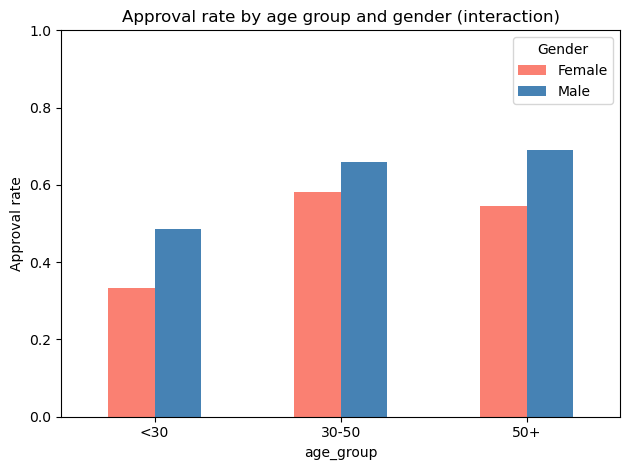

In [16]:
age_gender_approval = (
    df[mask & df['age_group'].notna()]
      .groupby(['age_group', 'gender_clean'], observed=False)[decision_col]
      .mean()
      .unstack()
)

print("Approval rate by age group and gender:")
print(age_gender_approval)

age_gender_approval.plot(kind='bar', rot=0, color=['salmon', 'steelblue'])
plt.ylabel('Approval rate')
plt.title('Approval rate by age group and gender (interaction)')
plt.ylim(0, 1)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

### Age × Gender Interpretation

To examine whether the gender approval gap is consistent across age groups, 
we computed approval rates for each combination of age group and gender.

| Age Group | Female | Male | Gap (M − F) |
|---|---|---|---|
| <30 | 33.3% | 48.5% | 15.2 pp |
| 30–50 | 58.1% | 66.0% | 7.9 pp |
| 50+ | 54.5% | 69.0% | 14.5 pp |

Several patterns emerge:

- **The gender gap is present in all three age groups**, confirming that the 
  overall female disadvantage is not driven by a single age segment.
- **The gap is largest for the <30 and 50+ groups** (15 percentage points), 
  and somewhat smaller for the 30–50 group (8 percentage points).
- **Younger applicants face a double disadvantage**: female applicants under 
  30 have the lowest approval rate in the entire dataset at just 33.3%, 
  combining the age penalty and the gender penalty simultaneously.
- **The 30–50 group is the most favourable** for both genders, but males in 
  this group still outperform females by nearly 8 percentage points.

These interaction effects suggest that fairness interventions should not treat 
gender and age independently — mitigation strategies such as reweighting or 
threshold adjustment may need to target specific subgroups (e.g. women under 
30) rather than applying uniform corrections across the board.

# ZIP Proxy Analysis

### Proxy Check with Crammer's V

In [17]:
zip_col = 'applicant_info.zip_code'

# Cramér's V between ZIP code and gender
cont_zip_gender = pd.crosstab(df[mask][zip_col], df[mask]['gender_clean'])
chi2_zg, p_zg, _, _ = chi2_contingency(cont_zip_gender)

n = cont_zip_gender.to_numpy().sum()
phi2 = chi2_zg / n
r, k = cont_zip_gender.shape
phi2_corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
r_corr = r - (r-1)**2/(n-1)
k_corr = k - (k-1)**2/(n-1)
cramers_v_zip_gender = np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

print(f"Cramér's V (ZIP vs Gender): {cramers_v_zip_gender:.4f}")
print("Interpretation: 0 = no association, 1 = perfect association")
if cramers_v_zip_gender > 0.3:
    print("  WARNING: Strong association — ZIP code may act as a proxy for gender.")
else:
    print("  OK: Weak association — ZIP code is unlikely to be a strong gender proxy.")


Cramér's V (ZIP vs Gender): 0.6327
Interpretation: 0 = no association, 1 = perfect association


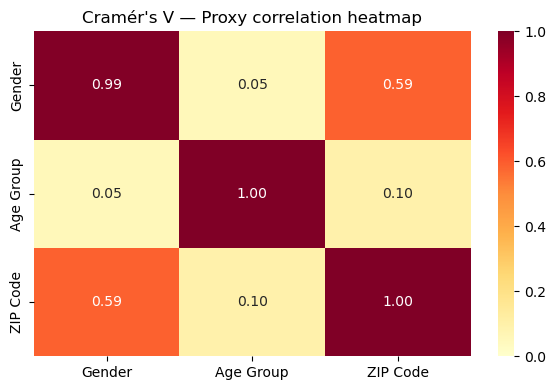

In [18]:
# Proxy correlation heatmap using Cramér's V

def cramers_v(x, y):
    cont = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(cont)
    n = cont.to_numpy().sum()
    phi2 = chi2 / n
    r, k = cont.shape
    phi2_corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    r_corr = r - (r-1)**2/(n-1)
    k_corr = k - (k-1)**2/(n-1)
    denom = min((k_corr-1), (r_corr-1))
    return np.sqrt(phi2_corr / denom) if denom > 0 else 0

# Build Cramér's V matrix
df_proxy = df[mask & df['age_group'].notna()].copy()

# ZIP is a string — use it directly as a category (no binning needed)
df_proxy['zip_cat'] = df_proxy[zip_col].astype(str)

variables = {
    'Gender':       df_proxy['gender_clean'],
    'Age Group':    df_proxy['age_group'].astype(str),
    'ZIP Code':     df_proxy['zip_cat']
}

var_names = list(variables.keys())
matrix = pd.DataFrame(index=var_names, columns=var_names, dtype=float)

for v1 in var_names:
    for v2 in var_names:
        matrix.loc[v1, v2] = cramers_v(variables[v1], variables[v2])

import seaborn as sns
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(matrix.astype(float), annot=True, fmt='.2f',
            cmap='YlOrRd', vmin=0, vmax=1, ax=ax)
ax.set_title("Cramér's V — Proxy correlation heatmap")
plt.tight_layout()
plt.show()

### Proxy Variable Check: ZIP Code

#### Motivation
Even when a protected attribute such as gender is excluded from a model, 
other variables may carry essentially the same information and act as 
**proxy features**. ZIP code is a classic example — if residential patterns 
differ systematically by gender, a model trained on ZIP code will implicitly 
discriminate by gender even without ever seeing the gender field.

#### Cramér's V Analysis
To quantify the association between ZIP code and gender we use **Cramér's V**, 
a normalised measure of association between two categorical variables ranging 
from 0 (no association) to 1 (perfect association). Unlike a simple count-based 
observation, Cramér's V provides a statistically grounded and comparable metric.

| Variable Pair | Cramér's V | Interpretation |
|---|---|---|
| ZIP Code vs Gender | **0.6327** | Strong association ⚠️ |

A Cramér's V of **0.6327** indicates a **strong association** between ZIP code 
and gender in this dataset. This means that knowing an applicant's ZIP code 
provides substantial information about their gender — and therefore that ZIP 
code could act as an effective proxy for gender in a predictive model.

#### Implications
- A model that includes ZIP code as a feature may **indirectly discriminate 
  by gender** even if the gender variable itself is removed.
- This is particularly concerning given that the gender DI ratio (0.770) 
  already falls below the 0.80 four-fifths threshold.
- Regulatory frameworks such as the EU AI Act require that proxy 
  discrimination of this kind be identified and mitigated.

#### Suggested Mitigations
- **Remove ZIP code** from any predictive model, or replace it with a 
  higher-level geographic indicator (e.g. region or province) that is 
  less correlated with gender.
- **Audit all geographic features** using Cramér's V before model training 
  to catch any other potential proxies.
- **Retest DI ratios** after removing ZIP code to confirm the gender gap 
  narrows, helping to isolate how much of the disparity is driven by 
  this proxy.


## Summary and Interpretations

### Gender Fairness
The disparate impact ratio for gender is 0.770, which falls below the 0.8 
four-fifths threshold, indicating potential bias against female applicants. 
The chi-square test confirms a statistically significant difference in approval 
rates between male and female applicants (Chi2 = 11.12, p = 0.0009).

Approved female applicants receive lower average interest rates (4.49% vs 4.63%)
but lower approved amounts (€46,669 vs €48,963) compared to males, suggesting 
disparities extend beyond the approval decision itself — females who do get 
approved receive smaller loans on average.

### Age Fairness
All three pairwise DI comparisons show that younger applicants (<30) face lower
approval rates than the 30–50 reference group. This may reflect genuinely different
financial profiles — younger applicants typically have shorter credit histories,
lower incomes, and higher debt-to-income ratios — rather than direct age 
discrimination.

### Proxy Variables
The Cramér's V between ZIP code and gender is 0.6327, indicating a strong 
association. ZIP codes are strongly correlated with gender in this dataset and 
should be treated as a proxy variable — using ZIP in a model would likely 
introduce indirect gender discrimination.

### Possible Confounders
Observed disparities may be partially or fully explained by financial variables
that differ systematically across demographic groups, such as:
- Income level and employment stability (tend to increase with age)
- Debt-to-income ratio
- Credit history length
- Collateral availability

These confounders do not eliminate fairness concerns but are important context
for interpreting the results.

### Suggested Mitigations
1. **Remove or constrain proxy features**: ZIP code shows a strong Cramér's V 
   of 0.6327 with gender — it should be removed or replaced with a less 
   correlated geographic indicator.
2. **Reweighting**: Apply sample reweighting during model training to balance
   approval rates across demographic groups.
3. **Threshold adjustment**: Use group-specific decision thresholds to equalise
   false positive/negative rates across gender and age groups.
4. **Regular fairness audits**: Monitor disparate impact ratios on new data 
   quarterly and trigger a review if any DI drops below 0.8.
5. **Feature review**: Evaluate whether debt-to-income ratio or credit history
   can replace age-correlated features to reduce indirect discrimination.
